In [7]:
import os
os.environ["OMP_NUM_THREADS"] = "20"

In [8]:
import pandas as pd
import numpy as np
from joblib import Parallel, delayed
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Regression code

In [9]:
import warnings
from scipy.linalg import lstsq
from scipy.stats import t as t_stat
from joblib import Parallel, delayed

def compute_column(X, y, coef, ss_res, rank, XtX_inv, constant, gene_name):
    n = X.shape[0]
    
    # Degrees of freedom
    df_model = rank - constant
    df_resid = n - rank
    ss_tot = y @ y
        
    mse = ss_res / df_resid
    beta_var = mse * XtX_inv
    beta_se = np.sqrt(beta_var)

    # Compute T and p-values
    T = coef / beta_se
    pval = 2 * t_stat.sf(np.fabs(T), df_resid)

    out = pd.DataFrame([pd.Series(coef, index=X.columns, name='coef'),
                        pd.Series(pval, index=X.columns, name='p')]).T
    if gene_name is not None:
        out['gene_name'] = gene_name

    return out

def least_squares(X, Y, coef_only=False, constant=False, XtX_inv=None, n_jobs=-1):
    """
    Perform ordinary least squares regression.
    
    Parameters:
    - X: DataFrame containing the independent variables.
    - Y: DataFrame containing the dependent variables.
    - coef_only: If True, returns only the coefficients.
    - constant: Boolean, indicating if there's a constant term in the regression.
    - n_jobs: Number of cores to use in parallel. -1 means using all processors.
    
    Returns:
    - Dictionary where each key corresponds to a dependent variable's column name and its associated value is the DataFrame containing coefficients and p-values for that dependent variable.
    """
    n = X.shape[0]

    # FIT LEAST SQUARES REGRESSION
    coef, ss_res, rank, _ = lstsq(X, Y, cond=None)
    
    calc_ss_res = False
    if rank < X.shape[1]:
        warnings.warn(
            "Design matrix supplied with `X` parameter is rank "
            f"deficient (rank {rank} with {X.shape[1]} columns). "
            "That means that one or more of the columns in `X` "
            "are a linear combination of one or more of the "
            "other columns."
        )
        calc_ss_res = True
        
    if coef_only:
        return coef

    if XtX_inv is None:
        XtX_inv = (np.linalg.pinv(X.T @ X).diagonal())

    if calc_ss_res:
        resid = Y.values - X.values @ coef
        ss_res = (resid**2).sum(axis=0)
    
    ss_res = pd.Series(ss_res, index=Y.columns)

    results = Parallel(n_jobs=n_jobs, verbose=10)(
        delayed(compute_column)(X, Y[col], coef[:, i], ss_res[col], rank, XtX_inv, constant, col)
        for i, col in enumerate(Y.columns)
    )
    
    results = pd.concat(results).pivot(columns='gene_name')
    return results['coef'], results['p']

# Genome-Scale CRISPR-Mediated Control of Gene Repression and Activation

## Loading data

In [10]:
# !wget https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4253859/bin/NIHMS630425-supplement-10.xlsx

In [11]:
crispra_data = pd.read_excel('NIHMS630425-supplement-10.xlsx', skiprows=1, sheet_name='CRISPRa Library')

crispra_data['sgRNA ID'] = crispra_data['sgRNA ID'].astype(str)
crispra_data = crispra_data[crispra_data['Protospacer sequence'].map(len) >= 20]
crispra_data['gene'] = crispra_data['sgRNA ID'].map(lambda x: x.split('-')[0])
crispra_data['sequence'] = crispra_data['Protospacer sequence'].map(lambda x: x[-8:-3].upper())

crispra_data = crispra_data[~crispra_data['Protospacer sequence'].str.contains('N') & ~crispra_data['gene'].str.contains('2014')]
crispra_data = crispra_data[crispra_data.groupby('gene').transform('count')['sgRNA ID'] >= 10].reset_index(drop=True)

/data/norman/tmn/envs/analysis38/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [12]:
crispri_data = pd.read_excel('NIHMS630425-supplement-10.xlsx', skiprows=1)

crispri_data['sgRNA ID'] = crispri_data['sgRNA ID'].astype(str)
crispri_data = crispri_data[crispri_data['Protospacer sequence'].map(len) >= 20]
crispri_data['gene'] = crispri_data['sgRNA ID'].map(lambda x: x.split('-')[0])
crispri_data['sequence'] = crispri_data['Protospacer sequence'].map(lambda x: x[-5:].upper())

crispri_data = crispri_data[~crispri_data['Protospacer sequence'].str.contains('N')]
crispri_data = crispri_data[crispri_data.groupby('gene').transform('count')['sgRNA ID'] >= 10].reset_index(drop=True)

/data/norman/tmn/envs/analysis38/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


## CRISPRa experiment

In [7]:
gene_design_matrix = pd.Series(1, index=pd.MultiIndex.from_arrays([crispra_data.index, crispra_data['gene']])).astype(np.float32).unstack(fill_value=0)

/data/norman/tmn/envs/analysis38/lib/python3.8/site-packages/pandas/core/reshape/reshape.py:134: PerformanceWarning: The following operation may generate 3126533385 cells in the resulting pandas object.
  warnings.warn(


In [8]:
sequence_design_matrix = pd.Series(1, index=pd.MultiIndex.from_arrays([crispra_data.index, crispra_data['sequence']])).astype(np.float32).unstack(fill_value=0)
sequence_design_matrix = sequence_design_matrix.loc[:, sequence_design_matrix.sum() >= 20]
sequence_design_matrix.columns = sequence_design_matrix.columns + '_s'

design_matrix = pd.concat([gene_design_matrix, sequence_design_matrix], axis=1)

In [9]:
Y = crispra_data.loc[design_matrix.index, ['Growth phenotype (gamma)', 'CTx-DTA phenotype (rho)']].astype(np.float32)
Y.columns = ['gamma', 'rho']

In [10]:
del gene_design_matrix
del sequence_design_matrix
import gc
gc.collect()

106

In [11]:
del design_matrix['negative_control']

In [12]:
design_matrix['intercept'] = np.float32(1.)

In [13]:
crispra_coefs, crispra_ps = least_squares(design_matrix,
                          Y,
                          coef_only=False, n_jobs=2)

/tmp/ipykernel_118400/2808016983.py:52: UserWarning: Design matrix supplied with `X` parameter is rank deficient (rank 16805 with 16806 columns). That means that one or more of the columns in `X` are a linear combination of one or more of the other columns.
  warnings.warn(
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    8.7s finished


In [14]:
# crispra_coefs.to_csv('20240403_CRISPRa_coefs.csv')
# crispra_ps.to_csv('20240403_CRISPRa_ps.csv')

In [13]:
# crispra_coefs = pd.read_csv('20240403_CRISPRa_coefs.csv', index_col=0)
# crispra_ps = pd.read_csv('20240403_CRISPRa_ps.csv', index_col=0)

In [66]:
seqs = crispra_data.query('gene=="negative_control"').groupby('sequence').count()['gene'][crispra_data.query('gene=="negative_control"').groupby('sequence').count()['gene'] >= 10].index
control_effects = crispra_data.query('gene=="negative_control"').groupby('sequence').median().loc[seqs]
control_effects.index = control_effects.index + '_s'

/data/norman/tmn/envs/analysis38/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


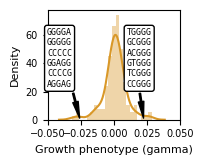

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=[2, 1.75])

# Create the histogram using seaborn's distplot
sns.distplot(control_effects['Growth phenotype (gamma)'], color='#D99828')

# Get the minimum and maximum values of the 'Growth phenotype (gamma)' column
min_value = control_effects['Growth phenotype (gamma)'].min()
max_value = control_effects['Growth phenotype (gamma)'].max()

# Get the indices of the 5 most negative and 5 most positive points
neg_indices = control_effects['Growth phenotype (gamma)'].nsmallest(6).index.map(lambda x: x.split('_')[0])
pos_indices = control_effects['Growth phenotype (gamma)'].nlargest(6).index.map(lambda x: x.split('_')[0])

# Create the annotation text for negative and positive outliers
neg_text = "\n".join(neg_indices)
pos_text = "\n".join(pos_indices)

# Get the y-axis limits and calculate the height of the distribution
ylim = plt.ylim()
height = ylim[1] - ylim[0]

# Calculate the y-coordinate for the text boxes (80% of the distribution height)
y_coord = ylim[0] + height * 0.3

# Adjust the font size
font_size = 6

# Calculate the x-coordinate for the negative outliers (2% of the x-axis range from the minimum value)
neg_x_coord = min_value + (max_value - min_value) * 0.1

# Calculate the x-coordinate for the positive outliers (2% of the x-axis range from the maximum value)
pos_x_coord = max_value - (max_value - min_value) * 0.1

# Add text box annotations for negative and positive outliers
plt.annotate(neg_text, xy=(neg_x_coord, ylim[0]), xytext=(min_value, y_coord),
             fontfamily='monospace', ha='right',
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=4),
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'),
             fontsize=font_size)

plt.annotate(pos_text, xy=(pos_x_coord, ylim[0]), xytext=(max_value, y_coord),
             fontfamily='monospace', ha='right',
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=4),
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'),
             fontsize=font_size)

# Set the font size for axis labels
plt.xlabel('Growth phenotype (gamma)', fontsize=8)
plt.ylabel('Density', fontsize=8)

# Set the font size for tick labels
plt.tick_params(axis='both', which='major', labelsize=7)

plt.xlim([-0.05, 0.05])
plt.tight_layout()
plt.savefig('20240405_CRISPRa_control_sgRNA_phenotypes.pdf', bbox_inches='tight')
plt.show()

In [68]:
table = pd.DataFrame([crispra_coefs['gamma'], -np.log10(crispra_ps['gamma'])], index=['gamma', '-log p']).T

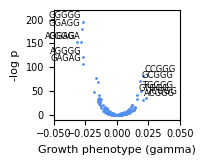

In [69]:
import matplotlib.pyplot as plt

plt.figure(figsize=[2,1.75])

# Create the scatter plot
plt.scatter(table[table.index.str.contains('_s')]['gamma'],
            table[table.index.str.contains('_s')]['-log p'], s=1, c='#528FF0')

# Set the x-axis label and limits
plt.xlabel('Growth phenotype (gamma)')
plt.xlim([-0.05, 0.05])

# Get the top outliers for positive and negative gamma values
pos_outliers = table[table.index.str.contains('_s')].nlargest(6, 'gamma')
neg_outliers = table[table.index.str.contains('_s')].nsmallest(6, 'gamma')

# Annotate the top positive outliers
for idx, row in pos_outliers.iterrows():
    plt.annotate(idx.split('_')[0], xy=(row['gamma'], row['-log p']),
                 xytext=(1, 1), textcoords='offset points',
                 fontsize=6, ha='left', va='bottom')

# Annotate the top negative outliers
for idx, row in neg_outliers.iterrows():
    plt.annotate(idx.split('_')[0], xy=(row['gamma'], row['-log p']),
                 xytext=(-1, 1), textcoords='offset points',
                 fontsize=6, ha='right', va='bottom')

plt.ylim([-10, 220])
plt.xlabel('Growth phenotype (gamma)', fontsize=8)

plt.ylabel('-log p', fontsize=8)
plt.tick_params(axis='both', which='major', labelsize=7)
plt.tight_layout()
plt.savefig('20240405_CRISPRa_seed_phenotypes.pdf', bbox_inches='tight')

plt.show()

## CRISPRi experiment

In [66]:
gene_design_matrix = pd.Series(1, index=pd.MultiIndex.from_arrays([crispri_data.index, crispri_data['gene']])).astype(np.float32).unstack(fill_value=0)

In [67]:
sequence_design_matrix = pd.Series(1, index=pd.MultiIndex.from_arrays([crispri_data.index, crispri_data['sequence']])).astype(np.float32).unstack(fill_value=0)
sequence_design_matrix = sequence_design_matrix.loc[:, sequence_design_matrix.sum() >= 20]
sequence_design_matrix.columns = sequence_design_matrix.columns + '_s'

design_matrix = pd.concat([gene_design_matrix, sequence_design_matrix], axis=1)

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f4b84666bb0>>
Traceback (most recent call last):
  File "/data/norman/tmn/envs/analysis38/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 

KeyboardInterrupt



In [ ]:
Y = crispri_data.loc[design_matrix.index, ['Growth phenotype (gamma)', 'CTx-DTA phenotype (rho)']].astype(np.float32)
Y.columns = ['gamma', 'rho']

In [ ]:
del gene_design_matrix
del sequence_design_matrix
import gc
gc.collect()

In [ ]:
del design_matrix['negative_control']

In [ ]:
design_matrix['intercept'] = np.float32(1.)

In [ ]:
crispri_coefs, crispri_ps = least_squares(design_matrix,
                          Y,
                          coef_only=False, n_jobs=2)

In [ ]:
# crispri_coefs.to_csv('20240403_CRISPRi_coefs.csv')
# crispri_ps.to_csv('20240403_CRISPRi_ps.csv')

In [40]:
crispri_coefs = pd.read_csv('20240403_CRISPRi_coefs.csv', index_col=0)
crispri_ps = pd.read_csv('20240403_CRISPRi_ps.csv', index_col=0)

In [71]:
seqs = crispri_data.query('gene=="negative_control"').groupby('sequence').count()['gene'][crispri_data.query('gene=="negative_control"').groupby('sequence').count()['gene'] >= 10].index
control_effects = crispri_data.query('gene=="negative_control"').groupby('sequence').median().loc[seqs]
control_effects.index = control_effects.index + '_s'

/data/norman/tmn/envs/analysis38/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


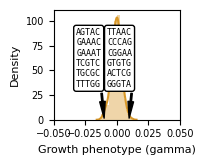

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=[2, 1.75])

# Create the histogram using seaborn's distplot
sns.distplot(control_effects['Growth phenotype (gamma)'], color='#D99828')

# Get the minimum and maximum values of the 'Growth phenotype (gamma)' column
min_value = control_effects['Growth phenotype (gamma)'].min()
max_value = control_effects['Growth phenotype (gamma)'].max()

# Get the indices of the 5 most negative and 5 most positive points
neg_indices = control_effects['Growth phenotype (gamma)'].nsmallest(6).index.map(lambda x: x.split('_')[0])
pos_indices = control_effects['Growth phenotype (gamma)'].nlargest(6).index.map(lambda x: x.split('_')[0])

# Create the annotation text for negative and positive outliers
neg_text = "\n".join(neg_indices)
pos_text = "\n".join(pos_indices)

# Get the y-axis limits and calculate the height of the distribution
ylim = plt.ylim()
height = ylim[1] - ylim[0]

# Calculate the y-coordinate for the text boxes (80% of the distribution height)
y_coord = ylim[0] + height * 0.3

# Adjust the font size
font_size = 6

# Calculate the x-coordinate for the negative outliers (2% of the x-axis range from the minimum value)
neg_x_coord = min_value + (max_value - min_value) * 0.1

# Calculate the x-coordinate for the positive outliers (2% of the x-axis range from the maximum value)
pos_x_coord = max_value - (max_value - min_value) * 0.1

# Add text box annotations for negative and positive outliers
plt.annotate(neg_text, xy=(neg_x_coord, ylim[0]), xytext=(min_value, y_coord),
             fontfamily='monospace', ha='right',
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=4),
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'),
             fontsize=font_size)

plt.annotate(pos_text, xy=(pos_x_coord, ylim[0]), xytext=(max_value, y_coord),
             fontfamily='monospace', ha='right',
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=4),
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'),
             fontsize=font_size)

# Set the font size for axis labels
plt.xlabel('Growth phenotype (gamma)', fontsize=8)
plt.ylabel('Density', fontsize=8)

# Set the font size for tick labels
plt.tick_params(axis='both', which='major', labelsize=7)

plt.xlim([-0.05, 0.05])
plt.tight_layout()
plt.savefig('20240405_CRISPRi_control_sgRNA_phenotypes.pdf', bbox_inches='tight')

plt.show()

In [73]:
table = pd.DataFrame([crispri_coefs['gamma'], -np.log10(crispri_ps['gamma'])], index=['gamma', '-log p']).T

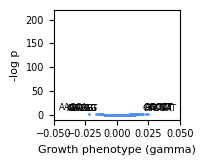

In [74]:
import matplotlib.pyplot as plt

plt.figure(figsize=[2,1.75])

# Create the scatter plot
plt.scatter(table[table.index.str.contains('_s')]['gamma'],
            table[table.index.str.contains('_s')]['-log p'], s=1, c='#528FF0')

# Set the x-axis label and limits
plt.xlabel('Growth phenotype (gamma)')
plt.xlim([-0.05, 0.05])

# Get the top outliers for positive and negative gamma values
pos_outliers = table[table.index.str.contains('_s')].nlargest(6, 'gamma')
neg_outliers = table[table.index.str.contains('_s')].nsmallest(6, 'gamma')

# Annotate the top positive outliers
for idx, row in pos_outliers.iterrows():
    plt.annotate(idx.split('_')[0], xy=(row['gamma'], row['-log p']),
                 xytext=(1, 1), textcoords='offset points',
                 fontsize=6, ha='left', va='bottom')

# Annotate the top negative outliers
for idx, row in neg_outliers.iterrows():
    plt.annotate(idx.split('_')[0], xy=(row['gamma'], row['-log p']),
                 xytext=(-1, 1), textcoords='offset points',
                 fontsize=6, ha='right', va='bottom')

plt.ylim([-10, 220])
plt.xlabel('Growth phenotype (gamma)', fontsize=8)

plt.ylabel('-log p', fontsize=8)
plt.tick_params(axis='both', which='major', labelsize=7)
plt.tight_layout()
plt.savefig('20240405_CRISPRi_seed_phenotypes.pdf', bbox_inches='tight')


plt.show()

# Optimized libraries for CRISPR-Cas9 genetic screens with multiple modalities

## pXPR_109 Mel Sel SetAB 

In [91]:
doench_analysis = pd.read_excel('41467_2018_7901_MOESM8_ESM.xlsx',
                                header=[0], index_col=0,
                                sheet_name='pXPR_109 Mel Sel SetAB analysis')

In [92]:
#109 is dCas9-VP64 + PH from SAM system on sgRNA
#118 is just dCas9 (so only PH)

In [94]:
ind = pd.MultiIndex.from_tuples(doench_analysis['Perturbations'].str.split(';').explode().items())

lfcs = pd.Series(doench_analysis['Individual LFCs'].str.split(';').explode().values, index=ind).astype(float)

lfcs = lfcs.to_frame()
lfcs.columns = ['lfc']
lfcs['end'] = lfcs.index.get_level_values(1).map(lambda x: x[-5:])
lfcs.set_index('end', append=True, inplace=True)

In [99]:
well_represented_genes = lfcs.groupby(level=0).size().sort_values()[lfcs.groupby(level=0).size().sort_values()>=3].index

In [100]:
sequence_design_matrix = pd.Series(1, index=lfcs[lfcs.index.get_level_values(0).isin(well_represented_genes)].index).unstack(fill_value=0).astype(np.float32).droplevel(0).sort_index()

In [101]:
gene_design_matrix = pd.Series(1, index=lfcs[lfcs.index.get_level_values(0).isin(well_represented_genes)].index).unstack(fill_value=0, level=0).astype(np.float32).droplevel(1).sort_index()

In [102]:
sequence_design_matrix = sequence_design_matrix.loc[:, sequence_design_matrix.sum() >= 10]
sequence_design_matrix.columns = sequence_design_matrix.columns + '_s'

In [103]:
design_matrix = pd.concat([gene_design_matrix, sequence_design_matrix], axis=1)

In [104]:
design_matrix['intercept'] = 1

In [105]:
Y = lfcs.droplevel([0, 2])[['lfc']].loc[design_matrix.index].dropna().sort_index()

In [106]:
design_matrix = design_matrix.astype(np.float32).loc[Y.index]
Y = Y.astype(np.float32)

In [107]:
doench_coefs, doench_ps = least_squares(design_matrix,
                          Y,
                          coef_only=False, n_jobs=1)

/tmp/ipykernel_764408/2808016983.py:52: UserWarning: Design matrix supplied with `X` parameter is rank deficient (rank 19979 with 19980 columns). That means that one or more of the columns in `X` are a linear combination of one or more of the other columns.
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s


In [111]:
# doench_coefs.to_csv('20240403_doench_coefs.csv')
# doench_ps.to_csv('20240403_doench_ps.csv')

In [47]:
# doench_coefs = pd.read_csv('20240403_doench_coefs.csv', index_col=0)
# doench_ps = pd.read_csv('20240403_doench_ps.csv', index_col=0)

In [48]:
table = pd.DataFrame([doench_coefs['lfc'], -np.log10(doench_ps['lfc'])], index=['LFC', '-log p']).T

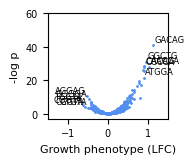

In [49]:
import matplotlib.pyplot as plt

plt.figure(figsize=[2,1.75])

# Create the scatter plot
plt.scatter(table[table.index.str.contains('_s')]['LFC'],
            table[table.index.str.contains('_s')]['-log p'], s=1, c='#528FF0')

# Set the x-axis label and limits
plt.xlabel('Growth phenotype (LFC)')
plt.xlim([-1.5, 1.5])

# Get the top outliers for positive and negative LFC values
pos_outliers = table[table.index.str.contains('_s')].nlargest(6, 'LFC')
neg_outliers = table[table.index.str.contains('_s')].nsmallest(6, 'LFC')

# Annotate the top positive outliers
for idx, row in pos_outliers.iterrows():
    plt.annotate(idx.split('_')[0], xy=(row['LFC'], row['-log p']),
                 xytext=(1, 1), textcoords='offset points',
                 fontsize=6, ha='left', va='bottom')

# Annotate the top negative outliers
for idx, row in neg_outliers.iterrows():
    plt.annotate(idx.split('_')[0], xy=(row['LFC'], row['-log p']),
                 xytext=(-1, 1), textcoords='offset points',
                 fontsize=6, ha='right', va='bottom')

plt.ylim([-3, 60])
plt.xlabel('Growth phenotype (LFC)', fontsize=8)

plt.ylabel('-log p', fontsize=8)
plt.tick_params(axis='both', which='major', labelsize=7)
plt.tight_layout()
plt.savefig('20240405_Doench_seed_phenotypes.pdf', bbox_inches='tight')

plt.show()

## pXPR_118 A375 Vem SetA 

In [115]:
doench_analysis = pd.read_excel('41467_2018_7901_MOESM8_ESM.xlsx',
                                header=[0], index_col=0,
                                sheet_name='pXPR_118 A375 Vem SetA analysis')

In [116]:
#109 is dCas9-VP64 + PH from SAM system on sgRNA
#118 is just dCas9 (so only PH)

In [117]:
ind = pd.MultiIndex.from_tuples(doench_analysis['Perturbations'].str.split(';').explode().items())

lfcs = pd.Series(doench_analysis['Individual LFCs'].str.split(';').explode().values, index=ind).astype(float)
lfcs = lfcs.to_frame()
lfcs.columns = ['lfc']
lfcs['end'] = lfcs.index.get_level_values(1).map(lambda x: x[-5:])
lfcs.set_index('end', append=True, inplace=True)

In [122]:
well_represented_genes = lfcs.groupby(level=0).size().sort_values()[lfcs.groupby(level=0).size().sort_values()>=3].index

In [123]:
sequence_design_matrix = pd.Series(1, index=lfcs[lfcs.index.get_level_values(0).isin(well_represented_genes)].index).unstack(fill_value=0).astype(np.float32).droplevel(0).sort_index()

In [124]:
gene_design_matrix = pd.Series(1, index=lfcs[lfcs.index.get_level_values(0).isin(well_represented_genes)].index).unstack(fill_value=0, level=0).astype(np.float32).droplevel(1).sort_index()

In [125]:
sequence_design_matrix = sequence_design_matrix.loc[:, sequence_design_matrix.sum() >= 10]
sequence_design_matrix.columns = sequence_design_matrix.columns + '_s'

In [126]:
design_matrix = pd.concat([gene_design_matrix, sequence_design_matrix], axis=1)

In [127]:
design_matrix['intercept'] = 1

In [128]:
Y = lfcs.droplevel([0, 2])[['lfc']].loc[design_matrix.index].dropna().sort_index()

In [129]:
design_matrix = design_matrix.astype(np.float32).loc[Y.index]
Y = Y.astype(np.float32)

In [130]:
doench_coefs, doench_ps = least_squares(design_matrix,
                          Y,
                          coef_only=False, n_jobs=1)

/tmp/ipykernel_764408/2808016983.py:52: UserWarning: Design matrix supplied with `X` parameter is rank deficient (rank 19590 with 19591 columns). That means that one or more of the columns in `X` are a linear combination of one or more of the other columns.
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.4s


In [131]:
# doench_coefs.to_csv('20240403_doench_PH_coefs.csv')
# doench_ps.to_csv('20240403_doench_PH_ps.csv')

In [44]:
# doench_coefs = pd.read_csv('20240403_doench_PH_coefs.csv', index_col=0)
# doench_ps = pd.read_csv('20240403_doench_PH_ps.csv', index_col=0)

In [45]:
table = pd.DataFrame([doench_coefs['lfc'], -np.log10(doench_ps['lfc'])], index=['LFC', '-log p']).T

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=[2,1.75])

# Create the scatter plot
plt.scatter(table[table.index.str.contains('_s')]['LFC'],
            table[table.index.str.contains('_s')]['-log p'], s=1, c='#528FF0')

# Set the x-axis label and limits
plt.xlabel('Growth phenotype (LFC)')
plt.xlim([-1.5, 1.5])

# Get the top outliers for positive and negative LFC values
pos_outliers = table[table.index.str.contains('_s')].nlargest(6, 'LFC')
neg_outliers = table[table.index.str.contains('_s')].nsmallest(6, 'LFC')

# Annotate the top positive outliers
for idx, row in pos_outliers.iterrows():
    plt.annotate(idx.split('_')[0], xy=(row['LFC'], row['-log p']),
                 xytext=(1, 1), textcoords='offset points',
                 fontsize=6, ha='left', va='bottom')

# Annotate the top negative outliers
for idx, row in neg_outliers.iterrows():
    plt.annotate(idx.split('_')[0], xy=(row['LFC'], row['-log p']),
                 xytext=(-1, 1), textcoords='offset points',
                 fontsize=6, ha='right', va='bottom')

plt.ylim([-3, 60])
plt.xlabel('Growth phenotype (LFC)', fontsize=8)

plt.ylabel('-log p', fontsize=8)
plt.tick_params(axis='both', which='major', labelsize=7)
plt.tight_layout()
plt.savefig('20240405_Doench_PH_seed_phenotypes.pdf', bbox_inches='tight')

plt.show()

# A genome–wide CRISPR activation screen identifies SCREEM a novel SNAI1 super-enhancer demarcated by eRNAs

In [1]:
# https://www.frontiersin.org/articles/10.3389/fmolb.2023.1110445/full
# !wget https://www.frontiersin.org/articles/file/downloadfile/1110445_supplementary-materials_tables_4_xlsx/octet-stream/Table%204.XLSX/1/1110445?isPublishedV2=False
# !mv 1110445?isPublishedV2=False Table4.xlsx

In [ ]:
cd44_low_counts = pd.read_excel('Table4.xlsx', sheet_name='CD44 LOW mageck_sgrna_summary')
cd44_low_counts['end'] = cd44_low_counts['sgrna'].map(lambda x: x[-5:].upper())

cd44_low_counts = cd44_low_counts.groupby('sgrna').head(1)

In [ ]:
well_represented = cd44_low_counts.groupby('GeneID').count()['sgrna']
well_represented = well_represented[well_represented >= 6].index

In [ ]:
gene_design_matrix = pd.Series(1, index=cd44_low_counts.query('GeneID in @well_represented').set_index(['sgrna', 'GeneID']).index).unstack(fill_value=0)

In [ ]:
sequence_design_matrix = pd.Series(1, index=cd44_low_counts.query('GeneID in @well_represented').set_index(['sgrna', 'end']).index).unstack(fill_value=0)

In [ ]:
sequence_design_matrix = sequence_design_matrix.loc[:, sequence_design_matrix.sum() >= 10]

In [ ]:
sequence_design_matrix.columns = sequence_design_matrix.columns + '_s'

In [ ]:
design_matrix = pd.concat([gene_design_matrix, sequence_design_matrix], axis=1)

In [ ]:
Y = cd44_low_counts.set_index('sgrna')[['LFC', 'score']].loc[design_matrix.index]

In [ ]:
del design_matrix['nontargeting']
design_matrix['intercept'] = 1

In [ ]:
design_matrix = design_matrix.astype(np.float32)
Y = Y.astype(np.float32)

In [ ]:
Y = Y.loc[design_matrix.index]

In [ ]:
cd44_coefs, cd44_ps = least_squares(design_matrix,
                          Y,
                          coef_only=False, n_jobs=1)

In [ ]:
table = pd.DataFrame([cd44_coefs['LFC'], -np.log10(cd44_ps['LFC'])], index=['LFC', '-log p']).T

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=[2,1.75])

# Create the scatter plot
plt.scatter(table[table.index.str.contains('_s')]['LFC'],
            table[table.index.str.contains('_s')]['-log p'], s=1, c='#528FF0')

# Set the x-axis label and limits
plt.xlabel('Growth phenotype (LFC)')
plt.xlim([-1.5, 1.5])

# Get the top outliers for positive and negative LFC values
pos_outliers = table[table.index.str.contains('_s')].nlargest(10, 'LFC')
neg_outliers = table[table.index.str.contains('_s')].nsmallest(6, 'LFC')

# Annotate the top positive outliers
for idx, row in pos_outliers.iterrows():
    plt.annotate(idx.split('_')[0], xy=(row['LFC'], row['-log p']),
                 xytext=(1, 1), textcoords='offset points',
                 fontsize=6, ha='left', va='bottom')

# # Annotate the top negative outliers
# for idx, row in neg_outliers.iterrows():
#     plt.annotate(idx.split('_')[0], xy=(row['LFC'], row['-log p']),
#                  xytext=(-1, 1), textcoords='offset points',
#                  fontsize=6, ha='right', va='bottom')

plt.ylim([-3, 60])
plt.xlabel('Growth phenotype (LFC)', fontsize=8)

plt.ylabel('-log p', fontsize=8)
plt.tick_params(axis='both', which='major', labelsize=7)
plt.tight_layout()
plt.savefig('20240405_CD44_seed_phenotypes.pdf', bbox_inches='tight')

plt.show()

# Genome-wide programmable transcriptional memory by CRISPR-based epigenome editing

In [ ]:
tiling_annotations = pd.read_excel('1-s2.0-S0092867421003536-mmc4.xlsx', sheet_name='Tiling protospacers', skiprows=3, header=[0], index_col=0)

In [ ]:
tiling_off_counts = pd.read_excel('1-s2.0-S0092867421003536-mmc4.xlsx', sheet_name='CRISPRoff', skiprows=4, header=[0], index_col=0)

In [ ]:
tiling_annotations['end'] = tiling_annotations['sequence'].map(lambda x: x[-5:].upper())

In [ ]:
tiling_off_counts['end'] = tiling_annotations['end']
tiling_off_counts['gene'] = tiling_off_counts.index.map(lambda x: x.split('_')[0] if 'non' not in x else 'non-targeting')
tiling_off_counts = tiling_off_counts.set_index(['gene', 'end'], append=True)

In [ ]:
control_effects = tiling_off_counts[tiling_off_counts.index.get_level_values(1).str.contains('non')].groupby(level=2).median().loc[seqs.index, 'ave_Rep1_Rep2']

control_effects.index = control_effects.index + '_s'

control_effects = pd.DataFrame(control_effects)
control_effects.columns = ['Growth phenotype (gamma)']

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=[2, 1.75])

# Create the histogram using seaborn's distplot
sns.distplot(control_effects['Growth phenotype (gamma)'], color='#D99828')

# Get the minimum and maximum values of the 'Growth phenotype (gamma)' column
min_value = control_effects['Growth phenotype (gamma)'].min()
max_value = control_effects['Growth phenotype (gamma)'].max()

# Get the indices of the 5 most negative and 5 most positive points
neg_indices = control_effects['Growth phenotype (gamma)'].nsmallest(8).index.map(lambda x: x.split('_')[0])
pos_indices = control_effects['Growth phenotype (gamma)'].nlargest(6).index.map(lambda x: x.split('_')[0])

# Create the annotation text for negative and positive outliers
neg_text = "\n".join(neg_indices)
pos_text = "\n".join(pos_indices)

# Get the y-axis limits and calculate the height of the distribution
ylim = plt.ylim()
height = ylim[1] - ylim[0]

# Calculate the y-coordinate for the text boxes (80% of the distribution height)
y_coord = ylim[0] + height * 0.3

# Adjust the font size
font_size = 6

# Calculate the x-coordinate for the negative outliers (2% of the x-axis range from the minimum value)
neg_x_coord = min_value + (max_value - min_value) * 0.1

# Calculate the x-coordinate for the positive outliers (2% of the x-axis range from the maximum value)
pos_x_coord = max_value - (max_value - min_value) * 0.1

# Add text box annotations for negative and positive outliers
plt.annotate(neg_text, xy=(neg_x_coord, ylim[0]), xytext=(min_value, y_coord),
             fontfamily='monospace', ha='right',
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=4),
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'),
             fontsize=font_size)

# plt.annotate(pos_text, xy=(pos_x_coord, ylim[0]), xytext=(max_value, y_coord),
#              fontfamily='monospace', ha='right',
#              arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=4),
#              bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'),
#              fontsize=font_size)

# Set the font size for axis labels
plt.xlabel('Growth phenotype (gamma)', fontsize=8)
plt.ylabel('Density', fontsize=8)

# Set the font size for tick labels
plt.tick_params(axis='both', which='major', labelsize=7)

plt.xlim([-0.075, 0.075])
plt.tight_layout()
plt.savefig('20240405_CRISPRoff_control_sgRNA_phenotypes.pdf', bbox_inches='tight')
plt.show()